# Can a Machine Beat the Best Tennis Player in the World?#
Since I'm both a big tennis fan and data nerd, I've long wanted to know how a machine learning algorithm would cope against the best fantasy tennis players in the world. Could it even beat them? To answer this question I will build a machine learning model and see if it will manage to predict the outcome of tennis matches better than the best fantasy tennis player in the world. More specifically I will set up a challenge that will consist of predicting which player will be the winner of a tennis match:
- I will use 1758 matches from all 66 ATP singles tournaments during 2018, excluding the ATP tour final. The year 2018 was chosen since it was the last complete season available at the time. More details about how the match selection was done can be found this blog post: https://medium.com/@marcusnilsson78/can-a-machine-beat-the-best-tennis-player-in-the-world-79112b47f547
- Only data available before a tournament started can be used to predict the match.
- The contestants in the challenge will be; a benchmark prediction, the best fantasy tennis player and the machine learning model which all will predict the outcome of the same matches.
- Accuracy will be used to measure how good the contestants predictions were. That means that the contestant that managed to correctly predict the most number of matches will win. Accuracy is calculated by taking number of correct predictions divided by all predictions. Eg. if 50 out of 100 matches are predict correctly, the accuracy will be 50%.

I'm using the fantasy tennis site www.tennisdrawchallenge.com to gather data about the best fantasy tennis player. When I build the machine learning model I use the files provided by Jeff Sackmann found here https://github.com/JeffSackmann/tennis_atp. Jeff has shared free high quality tennis data for years so a big thank you to him. With the data I do the following:
- All ATP including qualification plus challenger matches for year 2000-2018 is used as input for the model. The ATP tour final and RR tournaments are filtered out. I make sure that only data that was available before the match started is used.
- Only ATP matches for years 2008-2017 is used to train and test the model.
- The model will then predict the same 2018 matches as the benchmark prediction and the best fantasy tennis player.

This notebook is organized into these main parts:
- 0. Preparation
- 1. Benchmark Prediction
- 2. Best Fantasy Tennis Player Prediction
- 3. Machine Learning Prediction
- 4. Evaluate Challenge Predictions

----
# 0. Preparation
Import necessary libraries and set options.

In [4]:
# Install a conda package in the current Jupyter kernel - uncomment if needed
#import sys
#!conda install --yes --prefix {sys.prefix} xgboost

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import xgboost as xgb
import warnings
from time import time

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [6]:
# Set options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

----
# 1. Benchmark Prediction
To have something to compare the fantasy tennis player prediction and the machine learning prediction against I first created a benchmark prediction. The simple strategy of always picking the lowest ranked player as the winner of a match was used. The ATP ranking indicate a players performance during the last 52 weeks and a lower ranking is better.

## 1.1 Load and Prepare Data
Load data from file and only select needed columns and rows.

### 1.1.1 TDC Matches
I manually mapped the matches predicted by the best fantasy tennis player against the tourney_id and match_num that the ATP data use. The data was saved in a .csv file which is used as input for this analysis.

In [7]:
# Load tdc data
filename_tdc = 'data/tdc/tdc_2018.csv'
tdc_2018_raw_df = pd.read_csv(filename_tdc)

# Verify shape and content
print('Shape of tdc_2018_raw_df: {}'.format(tdc_2018_raw_df.shape))
tdc_2018_raw_df.head()

Shape of tdc_2018_raw_df: (2622, 5)


,tourney_id,match_num,match_played,correct_pick,countable_pick
0,2018-0301,271,1,1,1
1,2018-0301,272,1,1,1
2,2018-0301,273,1,0,1
3,2018-0301,275,1,1,1
4,2018-0301,276,1,1,1


In [53]:
# Filter and only select needed rows and columns
tdc_2018_df = tdc_2018_raw_df[['tourney_id', 'match_num']][tdc_2018_raw_df['countable_pick'] == 1]

# Verify shape and content
print('Shape of tdc_2018_df: {}'.format(tdc_2018_df.shape))
tdc_2018_df.head()

Shape of tdc_2018_df: (1758, 2)


,tourney_id,match_num
0,2018-0301,271
1,2018-0301,272
2,2018-0301,273
3,2018-0301,275
4,2018-0301,276


In [54]:
# Check for missing values
print(tdc_2018_df.isna().sum())

tourney_id    0
match_num     0
dtype: int64


### 1.1.2 ATP Matches
Load data about ATP matches available from Jeff Sackmann's github repository.

In [8]:
# Load atp data
filename_atp = 'data/atp/atp_matches_2018.csv'
atp_2018_raw_df = pd.read_csv(filename_atp)

# Verify shape and content
print('Shape of atp_2018_raw_df: {}'.format(atp_2018_raw_df.shape))
atp_2018_raw_df.head()

Shape of atp_2018_raw_df: (2889, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2018-M020,Brisbane,Hard,NaN,A,20180101,271,105992,NaN,NaN,Ryan Harrison,R,183.0,USA,25.65,104919,NaN,NaN,Leonardo Mayer,R,188.0,ARG,30.63,6-4 3-6 6-2,3,R32,123.0,9.0,2.0,82.0,49.0,39.0,20.0,13.0,8.0,9.0,10.0,3.0,80.0,47.0,33.0,19.0,14.0,1.0,4.0,47.0,1010.0,52.0,909.0
1,2018-M020,Brisbane,Hard,NaN,A,20180101,272,111577,NaN,NaN,Jared Donaldson,R,NaN,USA,21.23,111442,NaN,WC,Jordan Thompson,R,NaN,AUS,23.70,6-2 6-4,3,R32,90.0,5.0,3.0,58.0,32.0,25.0,14.0,9.0,4.0,5.0,3.0,5.0,62.0,41.0,25.0,7.0,9.0,7.0,11.0,54.0,890.0,94.0,593.0
2,2018-M020,Brisbane,Hard,NaN,A,20180101,273,104797,NaN,NaN,Denis Istomin,R,188.0,UZB,31.32,106000,7.0,NaN,Damir Dzumhur,R,172.0,BIH,25.62,6-7(4) 6-3 6-2,3,R32,145.0,7.0,0.0,94.0,66.0,48.0,12.0,14.0,9.0,11.0,8.0,6.0,120.0,53.0,37.0,29.0,15.0,10.0,16.0,63.0,809.0,30.0,1391.0
3,2018-M020,Brisbane,Hard,NaN,A,20180101,275,200282,NaN,WC,Alex De Minaur,R,NaN,AUS,18.87,105449,NaN,NaN,Steve Johnson,R,188.0,USA,28.02,7-6(7) 6-4,3,R32,104.0,9.0,3.0,66.0,37.0,32.0,17.0,11.0,2.0,3.0,6.0,2.0,80.0,43.0,33.0,17.0,11.0,4.0,6.0,208.0,245.0,44.0,1055.0
4,2018-M020,Brisbane,Hard,NaN,A,20180101,276,111581,NaN,Q,Michael Mmoh,R,NaN,USA,19.98,105643,NaN,NaN,Federico Delbonis,L,190.0,ARG,27.24,6-3 6-4,3,R32,69.0,5.0,4.0,55.0,38.0,32.0,11.0,10.0,3.0,3.0,4.0,0.0,45.0,35.0,28.0,5.0,9.0,0.0,2.0,175.0,299.0,68.0,755.0


In [56]:
# Exclude abnormal tournament types and keep only columns that are needed
columns = ['tourney_id', 'match_num', 'winner_rank', 'loser_rank']
atp_2018_df = atp_2018_raw_df[columns][~atp_2018_raw_df['tourney_level'].isin(['D', 'F'])] #Davis Cup & ATP Finals

# Verify shape and content
print('Shape of atp_2018_df: {}'.format(atp_2018_df.shape))
atp_2018_df.head()

Shape of atp_2018_df: (2622, 4)


,tourney_id,match_num,winner_rank,loser_rank
0,2018-M020,271,47.0,52.0
1,2018-M020,272,54.0,94.0
2,2018-M020,273,63.0,30.0
3,2018-M020,275,208.0,44.0
4,2018-M020,276,175.0,68.0


In [57]:
# Check for missing values
print(atp_2018_df.isna().sum())

tourney_id     0
match_num      0
winner_rank    0
loser_rank     3
dtype: int64


In [58]:
# Investigate rows with missing values
atp_2018_raw_df[(~atp_2018_raw_df['tourney_level'].isin(['D', 'F'])) & atp_2018_raw_df['loser_rank'].isna()] 

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
32,2018-0451,Doha,Hard,NaN,A,20180101,275,105882,NaN,Q,Stefano Travaglia,U,NaN,ITA,26.04,106325,NaN,WC,Jabor Al Mutawa,U,NaN,QAT,23.62,6-1 6-2,3,R32,53.0,8.0,2.0,34.0,20.0,19.0,9.0,7.0,0.0,0.0,0.0,2.0,50.0,40.0,19.0,3.0,8.0,4.0,9.0,134.0,414.0,NaN,NaN
91,2018-0301,Auckland,Hard,NaN,A,20180108,278,105138,5.0,NaN,Roberto Bautista Agut,R,183.0,ESP,29.74,105030,NaN,WC,Michael Venus,R,NaN,NZL,30.23,6-2 6-1,3,R32,56.0,3.0,1.0,51.0,37.0,29.0,7.0,8.0,5.0,6.0,3.0,3.0,42.0,18.0,11.0,4.0,7.0,2.0,7.0,21.0,1855.0,NaN,NaN
442,2018-7434,Sofia,Hard,NaN,A,20180205,283,104797,NaN,NaN,Denis Istomin,R,188.0,UZB,31.41,202090,NaN,WC,Adrian Andreev,U,NaN,BUL,16.74,6-3 6-4,3,R32,78.0,3.0,0.0,56.0,36.0,27.0,9.0,10.0,1.0,4.0,1.0,3.0,58.0,39.0,18.0,10.0,9.0,4.0,9.0,74.0,713.0,NaN,NaN


After a quick look on the ATP official web site we can see that all three players have not won any matches that count into the ranking at the point of their matches:
- https://www.atptour.com/en/players/jabor-al-mutawa/ac23/rankings-history
- https://www.atptour.com/en/players/michael-venus/v576/rankings-history
- https://www.atptour.com/en/players/adrian-andreev/a0ab/rankings-history

As the worst ranked players on the ATP ranking normally have a ranking of a little bit less than 2000, we will impute the missing values with the value 2000.

In [59]:
# Fill missing value
atp_2018_df['loser_rank'].fillna(2000, inplace=True)

# Verify that no missing values anymore
print(atp_2018_df.isna().sum())

tourney_id     0
match_num      0
winner_rank    0
loser_rank     0
dtype: int64


In [60]:
# Filter to only include matches selected for challenge
atp_2018_df = pd.merge(atp_2018_df, tdc_2018_df, how='inner', on=['tourney_id', 'match_num'])

# Verify shape and content
print('Shape of atp_2018_df: {}'.format(atp_2018_df.shape))
atp_2018_df.head()

Shape of atp_2018_df: (1758, 4)


,tourney_id,match_num,winner_rank,loser_rank
0,2018-M020,271,47.0,52.0
1,2018-M020,272,54.0,94.0
2,2018-M020,273,63.0,30.0
3,2018-M020,275,208.0,44.0
4,2018-M020,276,175.0,68.0


## 1.2 Calculate Benchmark Prediction

In [61]:
# Calculate prediction
all_matches = len(atp_2018_df)
correct_matches = len(atp_2018_df[atp_2018_df['winner_rank'] < atp_2018_df['loser_rank']])
benchmark_accuracy = round(100 * correct_matches / all_matches, 1)

# Display result
print('Benchmark prediction: {} of {} correct - {}%'.format(correct_matches, all_matches, benchmark_accuracy))

Benchmark prediction: 1101 of 1758 correct - 62.6%


----
# 2. Best Fantasy Tennis Player Prediction
See how well the best fantasy tennis player predicted matches on www.tennisdrawchallenge.com for 2018. Data has already been loaded in step 1.1.1 TDC Matches.

In [62]:
# Check prediction for fantasy tennis player
ftp_all = tdc_2018_raw_df[tdc_2018_raw_df['countable_pick'] == 1].countable_pick.sum()
ftp_correct = tdc_2018_raw_df[tdc_2018_raw_df['countable_pick'] == 1].correct_pick.sum()
ftp_accuracy = round(100 * ftp_correct / ftp_all, 1)

# Display result
print('FTP prediction: {} of {} correct - {}%'.format(ftp_correct, ftp_all, ftp_accuracy))

FTP prediction: 1168 of 1758 correct - 66.4%


----
# 3. Machine Learning Prediction
Check how well different machine learning models predict TDC matches for 2018.

## 3.1 Data Exploration
Load all ATP data and explore.

### 3.1.1 Load Data
Load all ATP data.

In [9]:
# Read in all files in training folder
filepath = 'data/atp/'
filenames = glob.glob(filepath + '*.csv')
li = []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [10]:
# Verify shape and content
print('Shape of df: {}'.format(df.shape))
df.head()

Shape of df: (176572, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2004-339,Adelaide,Hard,NaN,A,20040105,1,104379,NaN,WC,Todd Reid,R,180.0,AUS,19.59,101965,1.0,NaN,Wayne Ferreira,R,185.0,RSA,32.31,6-0 6-1,3,R32,35.0,1.0,0.0,31.0,21.0,20.0,8.0,7.0,0.0,0.0,1.0,3.0,33.0,14.0,5.0,6.0,6.0,0.0,5.0,243.0,145.0,26.0,1125.0
1,2004-339,Adelaide,Hard,NaN,A,20040105,2,103171,NaN,NaN,Raemon Sluiter,R,185.0,NED,25.73,103084,NaN,NaN,Guillermo Canas,R,185.0,ARG,26.11,6-4 6-4,3,R32,88.0,4.0,3.0,79.0,47.0,34.0,19.0,10.0,7.0,7.0,3.0,0.0,59.0,47.0,33.0,6.0,10.0,1.0,3.0,59.0,608.0,272.0,124.0
2,2004-339,Adelaide,Hard,NaN,A,20040105,3,102106,NaN,NaN,Davide Sanguinetti,R,188.0,ITA,31.36,103305,NaN,Q,Daniel Elsner,R,183.0,GER,25.00,6-1 6-1,3,R32,42.0,4.0,1.0,41.0,27.0,19.0,8.0,7.0,4.0,5.0,1.0,5.0,38.0,18.0,6.0,5.0,7.0,4.0,10.0,65.0,542.0,152.0,250.0
3,2004-339,Adelaide,Hard,NaN,A,20040105,4,103813,6.0,NaN,Jarkko Nieminen,L,185.0,FIN,22.45,103325,NaN,NaN,Wesley Moodie,R,196.0,RSA,24.89,4-6 7-6(6) 7-5,3,R32,131.0,1.0,2.0,100.0,59.0,42.0,28.0,17.0,5.0,7.0,15.0,3.0,107.0,78.0,56.0,15.0,17.0,6.0,8.0,36.0,980.0,82.0,445.0
4,2004-339,Adelaide,Hard,NaN,A,20040105,5,102642,NaN,NaN,Cyril Saulnier,R,190.0,FRA,28.39,104068,4.0,NaN,Robby Ginepri,R,183.0,USA,21.25,6-3 6-4,3,R32,66.0,1.0,1.0,59.0,34.0,26.0,16.0,10.0,2.0,2.0,3.0,2.0,57.0,39.0,27.0,8.0,9.0,2.0,4.0,86.0,423.0,32.0,1055.0


In [65]:
# Check values for numerical columns
df.describe()

,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,0.0,1.765720e+05,176572.000000,176572.000000,75164.000000,132525.000000,176542.000000,176572.000000,41381.000000,115595.000000,176185.000000,176572.000000,112954.000000,117081.000000,117081.000000,117081.00000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,175117.000000,175117.000000,170789.000000,170789.000000
mean,NaN,2.009890e+07,137.569603,105835.891970,5.636741,184.896065,25.593767,106740.809981,6.430101,184.676162,25.356508,3.158632,98.597323,5.822414,2.614147,72.71372,44.611833,33.389278,15.514900,11.604872,3.342336,4.912548,4.271786,3.405096,75.550405,45.117372,29.497963,13.793997,11.427772,4.589242,8.452353,197.755381,690.971990,269.024925,447.837308
std,NaN,5.429129e+04,218.156142,8992.519225,5.086880,6.744445,3.836250,11851.891922,5.474779,6.662957,3.997997,0.540464,39.902990,4.987832,2.229551,26.06097,16.905193,11.905547,6.384606,3.680256,2.955902,3.870466,4.221294,2.475962,25.786734,17.070361,12.855240,6.669343,3.686145,3.111074,3.827974,200.792903,1294.134856,288.477736,717.630473
min,NaN,2.000010e+07,1.000000,100415.000000,1.000000,145.000000,14.800000,100415.000000,1.000000,145.000000,14.080000,3.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,NaN,2.005111e+07,12.000000,103580.000000,2.000000,180.000000,22.730000,103581.000000,3.000000,180.000000,22.420000,3.000000,72.000000,2.000000,1.000000,54.00000,32.000000,25.000000,11.000000,9.000000,1.000000,2.000000,1.000000,2.000000,57.000000,33.000000,20.000000,9.000000,9.000000,2.000000,6.000000,73.000000,168.000000,94.000000,122.000000
50%,NaN,2.010063e+07,24.000000,104386.000000,5.000000,185.000000,25.380000,104474.000000,5.000000,185.000000,25.160000,3.000000,92.000000,5.000000,2.000000,68.00000,42.000000,31.000000,15.000000,11.000000,3.000000,4.000000,3.000000,3.000000,71.000000,42.000000,28.000000,13.000000,10.000000,4.000000,8.000000,150.000000,331.000000,189.000000,247.000000
75%,NaN,2.015031e+07,247.000000,105226.000000,7.000000,188.000000,28.170000,105438.000000,8.000000,188.000000,28.030000,3.000000,120.000000,8.000000,4.000000,89.00000,54.000000,40.000000,19.000000,14.000000,5.000000,7.000000,6.000000,5.000000,91.000000,55.000000,37.000000,18.000000,14.000000,6.000000,11.000000,255.000000,650.000000,321.000000,524.000000
max,NaN,2.018112e+07,946.000000,208279.000000,35.000000,208.000000,58.360000,208279.000000,35.000000,208.000000,60.170000,5.000000,4756.000000,412.000000,23.000000,491.00000,361.000000,292.000000,82.000000,90.000000,24.000000,30.000000,103.000000,25.000000,489.000000,328.000000,284.000000,101.000000,91.000000,25.000000,34.000000,2220.000000,16950.000000,2257.000000,16950.000000


### 3.1.2 Analyse surface
All rows where surface is None is Davis Cup matches which will be filtered out.

In [66]:
# Check distribution of values
df.groupby('surface').size()

surface
Carpet     6120
Clay      72289
Grass     10373
Hard      87592
None         80
dtype: int64

In [67]:
# Check some examples
df[df['surface'] == 'None'].groupby('tourney_name', as_index=False).size().head()

tourney_name
Davis Cup G1 R1: ISR vs POR    4
Davis Cup G1 R1: NZL vs IND    4
Davis Cup G1 R1: PER vs ECU    4
Davis Cup G1 R1: ROU vs BLR    4
Davis Cup G1 R1: TPE vs CHN    4
dtype: int64

### 3.1.3 Analyse tourney_level
Meaning of codes are:
- **A**: All normal tournaments as ATP250 and ATP500 including qualification. Olympics are in this category as well but will be filtered out
- **C**: Challenger tournaments
- **D**: Davis Cup matches
- **F**: Masters and Next Gen Finals
- **G**: Grand Slam tournaments
- **M**: ATP Masters 1000 tournaments

In [68]:
# Check distribution of values
df.groupby('tourney_level').size()

tourney_level
A    43601
C    99088
D     5888
F      271
G    14580
M    13144
dtype: int64

In [69]:
# Check some examples
df[df['tourney_level'] == 'M'].groupby('tourney_name').size()

tourney_name
Canada Masters          1322
Cincinnati Masters      1335
Hamburg Masters          593
Indian Wells Masters    2037
Madrid Masters          1104
Miami Masters           2201
Monte Carlo Masters     1335
Paris Masters           1073
Rome Masters            1311
Shanghai Masters         739
Stuttgart Masters         94
dtype: int64

### 3.1.4 Analyse round
Meaning of codes are:
- **BR**: Bronze medal match in Olympics and Next Gen Finals
- **F**: Final
- **Q1**: Qualification round 1
- **Q2**: Qualification round 2
- **Q3**: Qualification round 3
- **QF**: Quarter-final
- **R128**: Round of 128
- **R16**: Round of 16
- **R32**: Round of 32
- **R64**: Round of 64
- **RR**: Round robin. All player meet each other in group.
- **SF**: Semi-final

In [70]:
# Check distribution of values
df.groupby('round').size()

round
BR          7
F        4151
Q1      15753
Q2       9359
Q3       3790
QF      16431
R128     5952
R16     32828
R32     64499
R64      9008
RR       6530
SF       8264
dtype: int64

In [71]:
# Check some examples
df[df['round'] == 'BR'].groupby('tourney_name', as_index=False).size().head(7)

tourney_name
Athens Olympics     1
Beijing Olympics    1
London Olympics     1
Next Gen Finals     2
Rio Olympics        1
Sydney Olympics     1
dtype: int64

### 3.1.5 Analyse tourney_id
Tournament id is specific for each tournament and year. First part of id is the year and then is a tournament id that is persistent over time.

In [72]:
# Tournament can change name, see if id is persistent over time
df[df['tourney_name'].isin(['Aix En Provence CH', 'Aix en Provence CH'])].groupby(['tourney_name', 'tourney_id']).size()

tourney_name        tourney_id
Aix En Provence CH  2003-1685     31
                    2004-1685     31
                    2017-7009     54
                    2018-7009     56
Aix en Provence CH  2014-7009     31
                    2015-7009     31
                    2016-7009     49
dtype: int64

## 3.2 Data Preparation

### 3.2.1 Filter Rows to Use
Exclude some tournaments and tournament types which are different than normal format.

In [73]:
# Exclude abnormal tournament types 
main_df = df[~df['tourney_level'].isin(['D', 'F'])] #Davis Cup & ATP Finals
main_df = main_df[~main_df['tourney_id'].isin(['2008-96', '2012-96', '2016-O16', '2017-7696'])] #Olympics
main_df = main_df[~main_df['tourney_id'].str.split(pat='-').str.get(1).isin(['6406', '0605', '615', '433', '506', '499', '339', '96'])] #Challenger tour final + various RR tournaments

# Verify rows and columns in df
print('Shape of main_df: {}'.format(main_df.shape))

Shape of main_df: (167244, 49)


### 3.2.2 Add and Modify Columns
Create a few new columns based on existing and also modify existing columns.

#### 3.2.2.1 tourney_id_per
Create a tournament id that is persistent over time.

In [74]:
# Create tourney_id that is persistent over time
main_df['tourney_id_per'] = main_df['tourney_id'].str.split(pat='-').str.get(1)

# Verify new column
main_df.groupby('tourney_id_per').size().head()

tourney_id_per
0083    167
0091    169
0213    151
0221    154
0228    160
dtype: int64

#### 3.2.2.2 tourney_year
Derive the tournament year from the tourney_id columns. It's needed to be able to filter later on.

In [75]:
# Create tourney_year that is needed to filter on later
main_df['tourney_year'] = main_df['tourney_id'].str.split(pat='-').str.get(0).astype(int)

# Verify new column
main_df.groupby('tourney_year').size()

tourney_year
2000     6606
2001     7009
2002     6433
2003     6907
2004     7264
2005     7420
2006     7761
2007     9674
2008     9651
2009     9348
2010     9090
2011     8839
2012     8826
2013     8892
2014     8847
2015     9227
2016    12457
2017    10451
2018    12542
dtype: int64

#### 3.2.2.3 round
Modify round to integer values so it can be used for calculations later.

In [76]:
# Replace round values
round_dict = {'Q1': 1,
              'Q2': 2,
              'Q3': 3,
              'R128': 4,
              'R64': 5,
              'R32': 6,
              'R16': 7,
              'QF': 8,
              'SF': 9,
              'F': 10} 
main_df['round'].replace(round_dict, inplace=True)

# Check values after modification
main_df.groupby('round').size()

round
1     15344
2      9143
3      3690
4      5952
5      8848
6     63571
7     32372
8     16187
9      8092
10     4045
dtype: int64

In [77]:
# Check some examples of round values
main_df[main_df['round'] == 10].head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,...,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_id_per,tourney_year
61,2000-891,Chennai,Hard,NaN,A,20000103,31,102259,4.0,NaN,Jerome Golmard,L,188.0,FRA,26.32,103082,NaN,NaN,Markus Hantschk,R,188.0,GER,22.12,6-3 6-7(6) 6-3,3,...,148.0,8.0,1.0,88.0,65.0,49.0,13.0,14.0,2.0,3.0,10.0,4.0,123.0,74.0,53.0,18.0,16.0,9.0,14.0,35.0,666.0,128.0,273.0,891,2000
92,2000-451,Doha,Hard,NaN,A,20000103,31,102148,3.0,NaN,Fabrice Santoro,R,178.0,FRA,27.07,102783,NaN,NaN,Rainer Schuettler,R,180.0,GER,23.69,3-6 7-5 3-0 RET,3,...,118.0,3.0,0.0,74.0,44.0,27.0,16.0,12.0,2.0,6.0,1.0,1.0,85.0,61.0,33.0,12.0,13.0,7.0,12.0,34.0,764.0,48.0,579.0,451,2000
123,2000-301,Auckland,Hard,NaN,A,20000110,31,102796,2.0,NaN,Magnus Norman,R,188.0,SWE,23.61,102021,NaN,NaN,Michael Chang,R,175.0,USA,27.88,3-6 6-3 7-5,3,...,140.0,6.0,8.0,87.0,50.0,41.0,12.0,15.0,3.0,7.0,3.0,4.0,102.0,54.0,38.0,18.0,15.0,5.0,10.0,14.0,1498.0,50.0,722.0,301,2000
154,2000-338,Sydney,Hard,NaN,A,20000110,31,103720,NaN,NaN,Lleyton Hewitt,R,180.0,AUS,18.87,101727,NaN,WC,Jason Stoltenberg,R,185.0,AUS,29.77,6-4 6-0,3,...,57.0,2.0,4.0,41.0,29.0,25.0,5.0,8.0,0.0,1.0,2.0,3.0,46.0,21.0,13.0,8.0,8.0,1.0,6.0,21.0,1232.0,94.0,419.0,338,2000
281,2000-580,Australian Open,Hard,NaN,G,20000117,127,101736,1.0,NaN,Andre Agassi,R,180.0,USA,29.72,102338,2.0,NaN,Yevgeny Kafelnikov,R,190.0,RUS,25.91,3-6 6-3 6-2 6-4,5,...,139.0,9.0,5.0,116.0,77.0,52.0,23.0,18.0,4.0,7.0,14.0,9.0,122.0,65.0,42.0,30.0,18.0,11.0,17.0,1.0,4135.0,2.0,2915.0,580,2000


#### 3.2.2.4 hth_id
Need two types of identifiers for head-to-head
- Since player A vs player B, is the same as player B vs player A we create an id that always have the player with lowest id number first. This id is used to aggregate on for the hth features. 
- Then we have an id that is specific for the match and is created by using winner_id first and then loser_id. This is used to join on when merging hth features to the correct match.

In [78]:
# Add identifier for unique head-to-head
main_df['hth_id'] = np.where(main_df['winner_id'] < main_df['loser_id'], 
                          main_df['winner_id'].map(str) + '_' + main_df['loser_id'].map(str), 
                          main_df['loser_id'].map(str) + '_' + main_df['winner_id'].map(str))

# Add identifier for match specific head-to-head
main_df['hth_id_match'] = main_df['winner_id'].map(str) + '_' + main_df['loser_id'].map(str)

# Check some examples
main_df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,...,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_id_per,tourney_year,hth_id,hth_id_match
31,2000-891,Chennai,Hard,NaN,A,20000103,1,103420,NaN,NaN,Michal Tabara,R,175.0,CZE,20.40,102338,1.0,NaN,Yevgeny Kafelnikov,R,190.0,RUS,25.87,6-4 6-2,3,...,1.0,57.0,37.0,25.0,12.0,9.0,2.0,3.0,4.0,5.0,57.0,23.0,16.0,13.0,9.0,3.0,7.0,123.0,339.0,2.0,2733.0,891,2000,102338_103420,103420_102338
32,2000-891,Chennai,Hard,NaN,A,20000103,2,102455,NaN,NaN,Lorenzo Manta,R,190.0,SUI,25.30,102720,NaN,NaN,Tomas Zib,R,178.0,CZE,23.92,7-5 6-2,3,...,1.0,69.0,42.0,31.0,16.0,10.0,4.0,4.0,4.0,2.0,70.0,50.0,31.0,9.0,10.0,5.0,8.0,115.0,230.0,111.0,323.0,891,2000,102455_102720,102455_102720
33,2000-891,Chennai,Hard,NaN,A,20000103,3,102093,NaN,NaN,Martin Damm,R,188.0,CZE,27.42,103294,NaN,NaN,Christophe Rochus,R,170.0,BEL,21.05,6-3 6-0,3,...,0.0,46.0,26.0,23.0,12.0,8.0,1.0,1.0,1.0,1.0,37.0,17.0,8.0,9.0,7.0,1.0,5.0,104.0,296.0,121.0,293.0,891,2000,102093_103294,102093_103294
34,2000-891,Chennai,Hard,NaN,A,20000103,4,101086,7.0,NaN,Ronald Agenor,R,180.0,USA,35.14,104156,NaN,WC,Sunil Kumar,R,NaN,IND,16.75,6-4 6-4,3,...,0.0,64.0,35.0,26.0,19.0,10.0,2.0,3.0,2.0,3.0,62.0,32.0,22.0,16.0,10.0,1.0,4.0,96.0,416.0,1199.0,3.0,891,2000,101086_104156,101086_104156
35,2000-891,Chennai,Hard,NaN,A,20000103,5,102259,4.0,NaN,Jerome Golmard,L,188.0,FRA,26.32,102689,NaN,Q,Martin Spottl,R,180.0,AUT,24.11,6-3 6-4,3,...,2.0,65.0,43.0,33.0,14.0,10.0,4.0,4.0,6.0,2.0,61.0,21.0,14.0,23.0,9.0,2.0,4.0,35.0,666.0,201.0,191.0,891,2000,102259_102689,102259_102689


### 3.2.3 Filter Columns to Use
Filter to only continue with the features I will use. Choose not to look into the in-match specific columns like aces and breakpoints at this point in time.

In [79]:
# Copy subset of columns
main_df = main_df[['tourney_id', 'tourney_id_per', 'tourney_year', 'tourney_date', 'match_num', 'surface', 'tourney_level', 
                   'round', 'hth_id', 'hth_id_match', 'winner_id', 'loser_id', 'winner_rank', 'loser_rank', 'winner_age', 
                   'loser_age', 'winner_ht', 'loser_ht']].copy()

# Verify rows and columns in df and see first rows
print('Shape of main_df: {}'.format(main_df.shape))
main_df.head()

Shape of main_df: (167244, 18)


,tourney_id,tourney_id_per,tourney_year,tourney_date,match_num,surface,tourney_level,round,hth_id,hth_id_match,winner_id,loser_id,winner_rank,loser_rank,winner_age,loser_age,winner_ht,loser_ht
31,2000-891,891,2000,20000103,1,Hard,A,6,102338_103420,103420_102338,103420,102338,123.0,2.0,20.40,25.87,175.0,190.0
32,2000-891,891,2000,20000103,2,Hard,A,6,102455_102720,102455_102720,102455,102720,115.0,111.0,25.30,23.92,190.0,178.0
33,2000-891,891,2000,20000103,3,Hard,A,6,102093_103294,102093_103294,102093,103294,104.0,121.0,27.42,21.05,188.0,170.0
34,2000-891,891,2000,20000103,4,Hard,A,6,101086_104156,101086_104156,101086,104156,96.0,1199.0,35.14,16.75,180.0,NaN
35,2000-891,891,2000,20000103,5,Hard,A,6,102259_102689,102259_102689,102259,102689,35.0,201.0,26.32,24.11,188.0,180.0


### 3.2.4 Impute Missing Values
Check for missing values and impute them if possible. The following reasoning is done:
- **rank**: Players with missing values don't have any ranking at the time of the match. This means they should be considered around the same as the worst ranked players on the ATP ranking. As they normally have a ranking a little bit less than 2000, I will impute missing values with 2000.
- **age**: Missing age is probably caused by the fact that they are very young players just starting to play on ATP level. Here we will impute missing values with 15.
- **height**: Here it's probably just not that strict that height is reported to ATP for less known players. Hard to find any logic to how old players could be but we will use average height to impute missing values.

In [80]:
# Check for missing values
main_df.isna().sum()

tourney_id            0
tourney_id_per        0
tourney_year          0
tourney_date          0
match_num             0
surface               0
tourney_level         0
round                 0
hth_id                0
hth_id_match          0
winner_id             0
loser_id              0
winner_rank         975
loser_rank         4616
winner_age           16
loser_age           357
winner_ht         41651
loser_ht          57345
dtype: int64

In [81]:
# Check value distribution
main_df[['winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht']].describe()

,winner_rank,loser_rank,winner_age,loser_age,winner_ht,loser_ht
count,166269.000000,162628.000000,167228.000000,166887.000000,125593.000000,109899.000000
mean,196.461493,266.494736,25.617185,25.380814,184.884898,184.670761
std,194.200318,282.714651,3.835924,3.991425,6.739884,6.659823
min,1.000000,1.000000,14.800000,14.080000,145.000000,145.000000
25%,76.000000,97.000000,22.750000,22.440000,180.000000,180.000000
50%,151.000000,190.000000,25.400000,25.180000,185.000000,185.000000
75%,255.000000,318.000000,28.190000,28.040000,188.000000,188.000000
max,2220.000000,2257.000000,58.360000,60.170000,208.000000,208.000000


In [82]:
# Replace missing rank with 2000
main_df['winner_rank'].fillna(2000, inplace=True)
main_df['loser_rank'].fillna(2000, inplace=True)

In [83]:
# Replace missing age with 15
main_df['winner_age'].fillna(15, inplace=True)
main_df['loser_age'].fillna(15, inplace=True)

In [84]:
# Replace missing height with average
main_df['winner_ht'].fillna(main_df['winner_ht'].mean(), inplace=True)
main_df['loser_ht'].fillna(main_df['loser_ht'].mean(), inplace=True)

In [85]:
# Verify that no missing values left
main_df.isna().sum().sum()

0

## 3.3 Feature Engineering
Based on my experience with watching and playing fantasy tennis I will focus on the following features:
- **surface**: Some players perform better on specific surfaces. Try beat Nadal on clay and you know what I mean :)
- **tourney_level**: Some good players have difficulties in the bigger tournaments, like Grand Slams
- **rank**: A players ranking indicate how well he has played for the last 52 weeks
- **age**: Very young and very old players might not perform as well as players during peak years
- **height**: Most good ranked players are quite tall
- **head-to-head**: A player might have more difficulties against specific players. Try some variations:
    - **hth**: Take into account all historic meetings
    - **hth_5**: Last 5 meetings
- **winrate**: How many percent of all matches a player has won is a good indicator of how good he is. Will try some variations:
    - **winrate**: All history
    - **winrate_10**: Last 10 matches
    - **winrate_surf**: All history specific for surface
    - **winrate_level**: All history specific for tourney_level
- **round**: How far into a tournament a player usually makes it to. Try some variations:
    - **round_avg_level**: Average round specific for tourney_level
    - **round-avg_tid**: Average round specific for tourney_id

### 3.3.1 Head-to-Head Features
Create hth features in separate table. We make sure that the sums doesn't include the latest match itself since we want status BEFORE the start of the match.

**NOTE** - takes a few minutes to run.

In [86]:
# Create hth subset
hth_df = main_df[['hth_id', 'hth_id_match', 'tourney_id', 'tourney_date', 'match_num']].copy()
hth_df.sort_values(['hth_id', 'tourney_date', 'match_num'], ascending=[True, True, True], inplace=True)

# Count wins and losses
hth_df['p1_win'] = np.where(hth_df['hth_id'] == hth_df['hth_id_match'], 1, 0)
hth_df['p2_win'] = np.where(hth_df['hth_id'] != hth_df['hth_id_match'], 1, 0)

# Add running sums, but exclude current row since we want status BEFORE start of match
hth_df['p1_win_cum'] = hth_df.groupby('hth_id')['p1_win'].cumsum(axis=0) - hth_df['p1_win']
hth_df['p2_win_cum'] = hth_df.groupby('hth_id')['p2_win'].cumsum(axis=0) - hth_df['p2_win']

# Add running sum for last 5 matches before current match
hth_df['p1_win_cum_5'] = hth_df.groupby('hth_id')['p1_win'].rolling(window=6, min_periods=1).sum().reset_index(level=0, drop=True) - hth_df['p1_win']
hth_df['p2_win_cum_5'] = hth_df.groupby('hth_id')['p2_win'].rolling(window=6, min_periods=1).sum().reset_index(level=0, drop=True) - hth_df['p2_win']

# Calculate hth rate
hth_df['hth_rate'] = np.where(hth_df['hth_id'] == hth_df['hth_id_match'], 
                              hth_df['p1_win_cum'] - hth_df['p2_win_cum'], 
                              hth_df['p2_win_cum'] - hth_df['p1_win_cum']).astype(float)

# Calculate hth rate last 5 matches
hth_df['hth_rate_5'] = np.where(hth_df['hth_id'] == hth_df['hth_id_match'], 
                                hth_df['p1_win_cum_5'] - hth_df['p2_win_cum_5'], 
                                hth_df['p2_win_cum_5'] - hth_df['p1_win_cum_5'])

# Verify shape and values
print('Shape of hth_df: {}'.format(hth_df.shape))
hth_df[hth_df['hth_id'].isin(['100644_103908', '100644_103819', '104792_104925'])].head(5) 

Shape of hth_df: (167244, 13)


,hth_id,hth_id_match,tourney_id,tourney_date,match_num,p1_win,p2_win,p1_win_cum,p2_win_cum,p1_win_cum_5,p2_win_cum_5,hth_rate,hth_rate_5
51340,100644_103819,103819_100644,2016-M009,20160509,281,0,1,0,0,0.0,0.0,0.0,0.0
51624,100644_103819,100644_103819,2016-0500,20160613,299,1,0,0,1,0.0,1.0,-1.0,-1.0
54640,100644_103819,103819_100644,2017-0500,20170619,300,0,1,1,1,1.0,1.0,0.0,0.0
55174,100644_103819,100644_103819,2017-0421,20170807,300,1,0,1,2,1.0,2.0,-1.0,-1.0
139134,100644_103908,100644_103908,2014-526,20140630,31,1,0,0,0,0.0,0.0,0.0,0.0


Finally we drop unnecessary columns and check range of hth values and that no NaN values exist.

In [87]:
# Drop unnecessary columns
hth_df.drop(['hth_id', 'hth_id_match', 'tourney_date', 'p1_win', 'p2_win', 'p1_win_cum', 'p2_win_cum', 'p1_win_cum_5', 'p2_win_cum_5'], axis=1, inplace=True)

# Check hth values and no missing values
hth_df.describe()

,match_num,hth_rate,hth_rate_5
count,167244.000000,167244.000000,167244.000000
mean,140.895811,0.099292,0.088404
std,218.573234,1.033475,0.890829
min,1.000000,-17.000000,-5.000000
25%,13.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000
75%,249.000000,0.000000,0.000000
max,946.000000,17.000000,5.000000


### 3.3.2 Round Features
We create specific table with one row per player per tournament. We make sure that the running average do not include the tournament itself since we want status BEFORE the start of the tournament.

In [88]:
# Create winner subset
round_w_df = main_df.groupby(['winner_id', 'tourney_id_per', 'tourney_id', 'tourney_level'], as_index=False)['round'].max()
round_w_df.rename(columns={'winner_id': 'player_id'}, inplace=True)
round_w_df['round'] = np.where(round_w_df['round'] == 10, 11, round_w_df['round']) #Set value to 11 if winner of final

# Create loser subset
round_l_df = main_df.groupby(['loser_id', 'tourney_id_per', 'tourney_id', 'tourney_level'], as_index=False)['round'].max()
round_l_df.rename(columns={'loser_id': 'player_id'}, inplace=True)

# Merge into one df
round_df = pd.concat([round_w_df, round_l_df], ignore_index=True, sort=True)
round_df = round_df.groupby(['player_id', 'tourney_id_per', 'tourney_id', 'tourney_level'], as_index=False)['round'].max() #Aggregate again since player could exist both as a winner and loser in a tournament
columns = ['player_id', 'tourney_id_per', 'tourney_id', 'tourney_level', 'round']
round_df = round_df[columns]
round_df.sort_values(['player_id', 'tourney_id'], ascending=[True, True], inplace=True)

# Add running average specific for tourney_level, but exclude current row since we want status BEFORE start of each tournament
round_df['round_sum_level'] = round_df.groupby(['player_id', 'tourney_level'])['round'].cumsum(axis=0) - round_df['round']
round_df['round_count_level'] = round_df.groupby(['player_id', 'tourney_level'])['round'].cumcount()
round_df['round_avg_level'] = round_df['round_sum_level'] / round_df['round_count_level']
round_df['round_avg_level'].fillna(0, inplace=True) #fill NaN created if players first tournament for tourney_level

# Add running average specific for tourney_id_per, but exclude current row since we want status BEFORE start of each tournament
round_df['round_sum_tid'] = round_df.groupby(['player_id', 'tourney_id_per'])['round'].cumsum(axis=0) - round_df['round']
round_df['round_count_tid'] = round_df.groupby(['player_id', 'tourney_id_per'])['round'].cumcount()
round_df['round_avg_tid'] = round_df['round_sum_tid'] / round_df['round_count_tid']
round_df['round_avg_tid'].fillna(round_df['round_avg_level'], inplace=True) #fill NaN created if players first year playing tournament

# Verify shape and values
print('Shape of round_df: {}'.format(round_df.shape))
round_df[round_df['player_id'].isin([126205])].head(5) 

Shape of round_df: (170448, 11)


,player_id,tourney_id_per,tourney_id,tourney_level,round,round_sum_level,round_count_level,round_avg_level,round_sum_tid,round_count_tid,round_avg_tid
164712,126205,3351,2015-3351,C,7,0,0,0.0,0,0,0.0
164715,126205,363,2015-363,C,6,7,1,7.0,0,0,7.0
164718,126205,422,2015-422,M,1,0,0,0.0,0,0,0.0
164720,126205,5067,2015-5067,C,7,13,2,6.5,0,0,6.5
164727,126205,560,2015-560,G,4,0,0,0.0,0,0,0.0


Finally we drop unnecessary columns and check that round is between 0 and 11 and that no NaN values exist.

In [89]:
# Drop unnecessary columns
round_df.drop(['tourney_id_per', 'tourney_level', 'round', 'round_sum_level', 'round_count_level', 'round_sum_tid', 'round_count_tid'], axis=1, inplace=True)

# Check round df
round_df.describe()

,player_id,round_avg_level,round_avg_tid
count,170448.000000,170448.000000,170448.000000
mean,106716.876842,5.686320,5.730741
std,11831.089940,2.113612,2.264467
min,100415.000000,0.000000,0.000000
25%,103581.000000,5.083333,5.000000
50%,104471.000000,6.514286,6.428571
75%,105426.000000,7.017897,7.000000
max,208279.000000,11.000000,11.000000


### 3.3.3 Win Rate Features

We create a detailed table with one row per player and match. We add if a player won or lost and add the running wins and running losses. We make sure that the running sums do not include the match itself since we want status BEFORE the start of the match. Lastly we calculate the win rate which is the number of matches won / by total number of matches played.

In [90]:
# Create wins subset
win_df = main_df[['winner_id', 'tourney_date', 'tourney_id', 'match_num', 'surface', 'tourney_level']].copy()
win_df.rename(columns={'winner_id': 'player_id'}, inplace=True)
win_df['win'] = 1

# Create losses subset
loss_df = main_df[['loser_id', 'tourney_date', 'tourney_id', 'match_num', 'surface', 'tourney_level']].copy()
loss_df.rename(columns={'loser_id': 'player_id'}, inplace=True)
loss_df['loss'] = 1

# Merge into one df and fill NaN with 0
winrate_df = pd.concat([win_df, loss_df], ignore_index=True, sort=True)
columns = ['player_id', 'tourney_date', 'tourney_id', 'match_num', 'surface', 'tourney_level', 'win', 'loss']
winrate_df = winrate_df[columns]
winrate_df.fillna(0, inplace=True)
winrate_df.sort_values(['player_id', 'tourney_date', 'tourney_id', 'match_num'], ascending=[True, True, True, True], inplace=True)

# Add running sums, but exclude current row since we want status BEFORE start of match
winrate_df['win_cum'] = winrate_df.groupby('player_id')['win'].cumsum(axis=0) - winrate_df['win']
winrate_df['loss_cum'] = winrate_df.groupby('player_id')['loss'].cumsum(axis=0) - winrate_df['loss']

# Add running sum for last 10 matches BEFORE current match
winrate_df['win_cum_10'] = winrate_df.groupby('player_id')['win'].rolling(window=11, min_periods=1).sum().reset_index(level=0, drop=True) - winrate_df['win']
winrate_df['loss_cum_10'] = winrate_df.groupby('player_id')['loss'].rolling(window=11, min_periods=1).sum().reset_index(level=0, drop=True) - winrate_df['loss']

# Add running sums specific for surface, but exclude current row since we want status BEFORE start of match
winrate_df['win_cum_surf'] = winrate_df.groupby(['player_id', 'surface'])['win'].cumsum(axis=0) - winrate_df['win']
winrate_df['loss_cum_surf'] = winrate_df.groupby(['player_id', 'surface'])['loss'].cumsum(axis=0) - winrate_df['loss']

# Add running sums specific for tourney_level, but exclude current row since we want status BEFORE start of match
winrate_df['win_cum_level'] = winrate_df.groupby(['player_id', 'tourney_level'])['win'].cumsum(axis=0) - winrate_df['win']
winrate_df['loss_cum_level'] = winrate_df.groupby(['player_id', 'tourney_level'])['loss'].cumsum(axis=0) - winrate_df['loss']

# Calculate winrate, fill NaN created if players first match
winrate_df['winrate'] = np.round(winrate_df['win_cum'] / (winrate_df['win_cum'] + winrate_df['loss_cum']), 4)
winrate_df['winrate_10'] = np.round(winrate_df['win_cum_10'] / (winrate_df['win_cum_10'] + winrate_df['loss_cum_10']), 4)
winrate_df['winrate_surf'] = np.round(winrate_df['win_cum_surf'] / (winrate_df['win_cum_surf'] + winrate_df['loss_cum_surf']), 4)
winrate_df['winrate_level'] = np.round(winrate_df['win_cum_level'] / (winrate_df['win_cum_level'] + winrate_df['loss_cum_level']), 4)
winrate_df.fillna(0, inplace=True)

# Verify shape and values
print('Shape of winrate_df: {}'.format(winrate_df.shape))
winrate_df[winrate_df['player_id'].isin([126205, 126774])].head(5)

Shape of winrate_df: (334488, 20)


,player_id,tourney_date,tourney_id,match_num,surface,tourney_level,win,loss,win_cum,loss_cum,win_cum_10,loss_cum_10,win_cum_surf,loss_cum_surf,win_cum_level,loss_cum_level,winrate,winrate_10,winrate_surf,winrate_level
134679,126205,20150420,2015-5067,16,Clay,C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
301931,126205,20150420,2015-5067,24,Clay,C,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0000,1.0000,1.0000,1.0000
134941,126205,20150427,2015-692,14,Clay,C,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5000,0.5000,0.5000,0.5000
302194,126205,20150427,2015-692,23,Clay,C,0.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,0.6667,0.6667,0.6667,0.6667
136492,126205,20150720,2015-670,3,Hard,C,1.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.5000,0.5000,0.0000,0.5000


Finally we drop unnecessary columns and check that winrate is between 0 and 1 and that no NaN values exist.

In [91]:
# Drop unnecessary columns
winrate_df.drop(['tourney_date', 'surface', 'tourney_level', 'win', 'loss', 'win_cum', 'loss_cum', 'win_cum_10', 'loss_cum_10', 'win_cum_surf', 'loss_cum_surf', 'win_cum_level', 'loss_cum_level'], axis=1, inplace=True)

# Check winrate df
winrate_df.describe()

,player_id,match_num,winrate,winrate_10,winrate_surf,winrate_level
count,334488.000000,334488.000000,334488.000000,334488.000000,334488.000000,334488.000000
mean,106325.164983,140.895811,0.489446,0.498714,0.490488,0.483496
std,10618.986037,218.572907,0.146781,0.203672,0.179284,0.176092
min,100415.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,103581.000000,13.000000,0.445900,0.400000,0.428600,0.420500
50%,104456.000000,25.000000,0.518200,0.500000,0.521700,0.505100
75%,105341.000000,249.000000,0.563300,0.600000,0.587700,0.583300
max,208279.000000,946.000000,1.000000,1.000000,1.000000,1.000000


### 3.3.4 Merge All Features
Filter all rows before 2008 as they were only used to calculate the historic features. Merge all features calculated separatly into the main dataframe. Features that are player specific are added for both players.

In [92]:
# Exclude extra rows used to calculate features
main_df = main_df[(main_df['tourney_year'] >= 2008) & (main_df['tourney_level'].isin(['A', 'G', 'M']))].copy()

# Add winrate to main for winner
main_df = pd.merge(main_df, winrate_df.rename(columns={'player_id': 'winner_id'}), how='left', on=['winner_id', 'tourney_id', 'match_num'])
main_df.rename(columns={'winrate': 'winner_winrate', 
                     'winrate_10': 'winner_winrate_10', 
                     'winrate_surf': 'winner_winrate_surf', 
                     'winrate_level': 'winner_winrate_level'}, inplace=True)

# Add winrate to main for loser
main_df = pd.merge(main_df, winrate_df.rename(columns={'player_id': 'loser_id'}), how='left', on=['loser_id', 'tourney_id', 'match_num'])
main_df.rename(columns={'winrate': 'loser_winrate', 
                     'winrate_10': 'loser_winrate_10', 
                     'winrate_surf': 'loser_winrate_surf', 
                     'winrate_level': 'loser_winrate_level'}, inplace=True)

# Add round to main for winner
main_df = pd.merge(main_df, round_df.rename(columns={'player_id': 'winner_id'}), how='left', on=['winner_id', 'tourney_id'])
main_df.rename(columns={'round_avg_level': 'w_round_avg_level', 
                     'round_avg_tid': 'w_round_avg_tid'}, inplace=True)

# Add round to main for loser
main_df = pd.merge(main_df, round_df.rename(columns={'player_id': 'loser_id'}), how='left', on=['loser_id', 'tourney_id'])
main_df.rename(columns={'round_avg_level': 'l_round_avg_level', 
                     'round_avg_tid': 'l_round_avg_tid'}, inplace=True)

# Add hth to main
main_df = pd.merge(main_df, hth_df, how='left', on=['tourney_id', 'match_num'])

# Verify shape and values
print('Shape of main_df: {}'.format(main_df.shape))
main_df.tail()

Shape of main_df: (44557, 32)


,tourney_id,tourney_id_per,tourney_year,tourney_date,match_num,surface,tourney_level,round,hth_id,hth_id_match,winner_id,loser_id,winner_rank,loser_rank,winner_age,loser_age,winner_ht,loser_ht,winner_winrate,winner_winrate_10,winner_winrate_surf,winner_winrate_level,loser_winrate,loser_winrate_10,loser_winrate_surf,loser_winrate_level,w_round_avg_level,w_round_avg_tid,l_round_avg_level,l_round_avg_tid,hth_rate,hth_rate_5
44552,2018-0352,0352,2018,20181029,202,Hard,M,2,105311_105815,105311_105815,105311,105815,48.0,62.0,29.58,27.27,185.0,184.670761,0.5136,0.5,0.4739,0.3784,0.4962,0.4,0.5025,0.2500,4.923077,6.0,0.000000,0.000000,0.0,0.0
44553,2018-0352,0352,2018,20181029,203,Hard,M,2,104291_104898,104898_104291,104898,104291,47.0,55.0,31.56,34.77,190.0,185.000000,0.5574,0.4,0.5115,0.5196,0.5332,0.6,0.5702,0.5366,4.926829,6.0,4.000000,2.000000,0.0,0.0
44554,2018-0352,0352,2018,20181029,204,Hard,M,2,103917_106045,103917_106045,103917,106045,169.0,63.0,36.77,26.20,190.0,180.000000,0.5472,0.4,0.5537,0.3646,0.5758,0.6,0.5799,0.4634,4.553571,6.5,3.277778,3.277778,0.0,0.0
44555,2018-0352,0352,2018,20181029,205,Hard,M,2,105077_105376,105376_105077,105376,105077,61.0,69.0,29.29,30.78,185.0,188.000000,0.5323,0.5,0.5846,0.4091,0.5534,0.4,0.3977,0.5310,3.000000,6.0,4.956522,6.000000,0.0,0.0
44556,2018-0352,0352,2018,20181029,206,Hard,M,2,103852_105051,103852_105051,103852,105051,71.0,39.0,37.11,30.92,188.0,188.000000,0.5255,0.3,0.5145,0.4685,0.5661,0.5,0.5580,0.4902,5.763780,6.0,2.761905,2.761905,1.0,1.0


### 3.3.5 Create Balanced Target Variable
Split the data into two to make sure the target variable will have 50% of each event. We verify and compare the distribution between sets to make sure they are similar.

In [93]:
# Split into two sets to balance target variable
df1 = main_df[main_df.index % 2 == 0].copy()
df2 = main_df[main_df.index % 2 == 1].copy()

# Verify
print('Shape of df1: {}'.format(df1.shape))
print('Shape of df2: {}'.format(df2.shape))

Shape of df1: (22279, 32)
Shape of df2: (22278, 32)


In [94]:
# Verify that tourney_date are evenly distributed
print('Average tourney_date for df1: {}'.format(round(df1['tourney_date'].mean(), 0)))
print('Average tourney_date for df2: {}'.format(round(df2['tourney_date'].mean(), 0)))

Average tourney_date for df1: 20128389.0
Average tourney_date for df2: 20128391.0


In [95]:
def get_df_name(df):
    '''
    Return name of dataframe as a string. Taken from:
    https://stackoverflow.com/questions/54137694/how-to-print-dataframe-name-in-title-of-a-plot
    
    INPUT:
    (dataframe) df - pandas dataframe
    
    OUTPUT:
    (str) name - name of the pandas dataframe
    '''
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [96]:
def compare_distribution(subsets, columns):
    '''
    Take a list of subsets and columns and print a distribution graph for each combination.
    
    INPUT:
    (list) subsets - list of datasets to compare against
    (list) columns - list of column names to compare distributions for
    
    OUTPUT:
    N/A
    '''
    # Set variables
    subset_size = len(subsets)
    column_size = len(columns)
    f_width = subset_size*6
    f_height = column_size*6
    plot_counter = 1
    base_color = sns.color_palette()[0]
    
    # Set figure size
    plt.figure(figsize = [f_width, f_height])
    
    # Create subplot for each column and subset
    for column in columns:
        for subset in subsets:
            # Generate tick mark locations and names
            tick_props = np.arange(0, 1.1, 0.10)
            tick_names = ['{:0.2f}'.format(v) for v in tick_props]
            
            # Create subplot
            plt.subplot(column_size, subset_size, plot_counter)
            ax = sns.countplot(x=column, data=subset, color=base_color)
            plt.yticks(tick_props * subset.shape[0], tick_names)
            plt.ylabel('Proportion')
            plt.grid(True, 'major', 'y')
            ax.set_title('Subset: {}'.format(get_df_name(subset)))
            
            # Increase plot counter
            plot_counter += 1
            
    # Display plot
    plt.show()

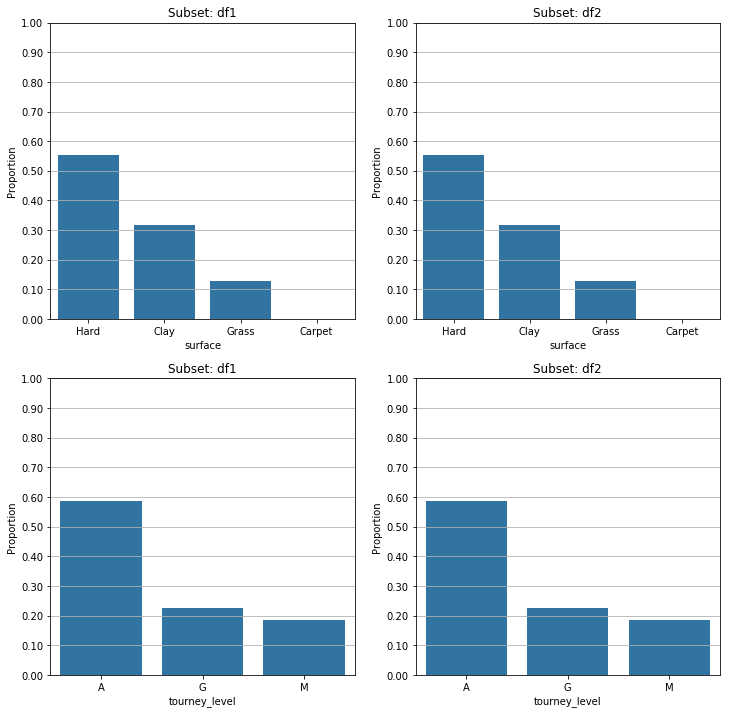

In [97]:
# Define subsets and columns to be compared
subset_list = [df1, df2]
column_list = ['surface', 'tourney_level']

# Compare distributions between subsets
compare_distribution(subset_list, column_list)

### 3.3.6 Create Match-specific Features
Need to take into account both players values for each feature. We do that by taking the difference of the features for the players and therefore get one set of features specific for the match.

In [98]:
# Define columns to drop
columns_drop = ['tourney_id_per', 'round', 'hth_id', 'hth_id_match', 'tourney_date', 'winner_id', 
                'loser_id', 'winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht', 
                'winner_winrate', 'loser_winrate', 'winner_winrate_10', 'loser_winrate_10', 'winner_winrate_surf', 
                'loser_winrate_surf', 'winner_winrate_level', 'loser_winrate_level', 'w_round_avg_level', 'l_round_avg_level', 'w_round_avg_tid', 'l_round_avg_tid']

In [99]:
# Calculate features for dataset 1
df1['rank_diff'] = df1['winner_rank'] - df1['loser_rank']
df1['age_diff'] = df1['winner_age'] - df1['loser_age']
df1['height_diff'] = df1['winner_ht'] - df1['loser_ht']

# Winrate features
df1['winrate_diff'] = df1['winner_winrate'] - df1['loser_winrate']
df1['winrate_diff_10'] = df1['winner_winrate_10'] - df1['loser_winrate_10']
df1['winrate_diff_surf'] = df1['winner_winrate_surf'] - df1['loser_winrate_surf']
df1['winrate_diff_level'] = df1['winner_winrate_level'] - df1['loser_winrate_level']

# Round features
df1['round_avg_level'] = df1['w_round_avg_level'] - df1['l_round_avg_level']
df1['round_avg_tid'] = df1['w_round_avg_tid'] - df1['l_round_avg_tid']

# Hth features
df1['hth_rate'] = df1['hth_rate']
df1['hth_rate_5'] = df1['hth_rate_5']

# Create target variable
df1['player_1_win'] = 1

# Drop unnecessary columns
df1.drop(columns_drop, axis=1, inplace=True)

# Check result
df1.head()

,tourney_id,tourney_year,match_num,surface,tourney_level,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
0,2008-891,2008,1,Hard,A,0.0,0.0,-121.0,-1.25,2.0,0.2540,0.3,0.2091,0.2705,4.566860,3.625000,1
2,2008-891,2008,3,Hard,A,0.0,0.0,-97.0,-2.94,5.0,-0.0367,0.2,-0.1629,0.0260,0.678992,4.500000,1
4,2008-891,2008,5,Hard,A,0.0,0.0,-108.0,8.73,2.0,0.1751,0.1,0.0727,0.4086,2.021670,4.250000,1
6,2008-891,2008,7,Hard,A,0.0,0.0,-32.0,0.64,-3.0,0.0014,0.2,0.0408,0.0089,0.932382,0.480769,1
8,2008-891,2008,9,Hard,A,0.0,0.0,-42.0,1.86,-7.0,-0.0161,0.0,-0.0541,0.0800,1.138889,1.138889,1


In [100]:
# Calculate features for dataset 2
df2['rank_diff'] = df2['loser_rank'] - df2['winner_rank']
df2['age_diff'] = df2['loser_age'] - df2['winner_age']
df2['height_diff'] = df2['loser_ht'] - df2['winner_ht']

# Winrate features
df2['winrate_diff'] = df2['loser_winrate'] - df2['winner_winrate']
df2['winrate_diff_10'] = df2['loser_winrate_10'] - df2['winner_winrate_10']
df2['winrate_diff_surf'] = df2['loser_winrate_surf'] - df2['winner_winrate_surf']
df2['winrate_diff_level'] = df2['loser_winrate_level'] - df2['winner_winrate_level']

# Round features
df2['round_avg_level'] = df2['l_round_avg_level'] - df2['w_round_avg_level']
df2['round_avg_tid'] = df2['l_round_avg_tid'] - df2['w_round_avg_tid']

# Hth features
df2['hth_rate'] = df2['hth_rate']*(-1)
df2['hth_rate_5'] = df2['hth_rate_5']*(-1)

# Create target variable
df2['player_1_win'] = 0

# Drop unnecessary columns
df2.drop(columns_drop, axis=1, inplace=True)

# Check result
df2.head()

,tourney_id,tourney_year,match_num,surface,tourney_level,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
1,2008-891,2008,2,Hard,A,-0.0,-0.0,-131.0,4.72,-5.0,0.0390,0.0,-0.0284,0.1833,0.388889,0.388889,0
3,2008-891,2008,4,Hard,A,-1.0,-1.0,260.0,-12.57,-5.0,-0.1701,0.3,-0.1565,-0.0105,-1.981481,-0.148148,0
5,2008-891,2008,6,Hard,A,-0.0,-0.0,23.0,2.07,5.0,-0.0688,0.2,-0.1969,0.0834,1.621849,2.257143,0
7,2008-891,2008,8,Hard,A,-1.0,-1.0,-28.0,5.23,-5.0,0.0511,0.1,0.0382,0.1266,0.559692,-1.500000,0
9,2008-891,2008,10,Hard,A,1.0,1.0,5.0,-2.80,8.0,0.0054,0.1,0.0505,-0.0698,-0.749300,-3.000000,0


In [101]:
# Combine into one dataset
total = pd.concat([df1, df2])

# Verify that target variable distribution is balanced
total.groupby('player_1_win').size()

player_1_win
0    22278
1    22279
dtype: int64

In [102]:
# Check average feature value for each target value
total.groupby('player_1_win').mean()

,tourney_year,match_num,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid
player_1_win,,,,,,,,,,,,,
0,2012.789972,308.791723,-0.217614,-0.179908,98.686327,-0.212203,-0.513101,-0.045789,-0.050523,-0.053141,-0.049192,-0.793296,-0.837659
1,2012.789712,308.773194,0.236007,0.195969,-96.007092,0.223555,0.514849,0.044834,0.053170,0.052465,0.048357,0.756691,0.801749


In [103]:
# Verify that no missing values
total.isna().sum().sum()

0

## 3.4 Feature Transformation
Take care of outliers, normalize numerical features and convert categorical variables.

### 3.4.1 Handle Outliers
Below I check how values are distributed for all numerical variables. If there are outliers it's important to know if they are caused by bad data quality or if they are correct. Since all of the extreme values below could be explained and seems correct, no data was eliminated in this step. The details for each feature are:
- **rank**: Range between -2000 and 2000. Since best ranking is 1 and worst around 2000 this is plausable.
- **age**: Range between -30 and 30. Since youngest player is 14 and oldest is 59 this is plausable.
- **height**: Range between -45 and 45. Since shortest player is 145 and tallest 208 this is plausable.
- **head-to-head**: 
    - **hth**: Range between -17 and 17. That a player has won 17 more matches against the same player is plausable. 
    - **hth_5**: Range between -5 and 5. Makes sense since we only use 5 last matches for this feature.
- **winrate**: 
    - **winrate**: Range between -0.8 and 0.8. Since win rate can be between 0 and 1 for each player this makes sense.
    - **winrate_10**: Range between -1 and 1. Since win rate can be between 0 and 1 for each player this makes sense.
    - **winrate_surf**: Range between -1 and 1. Since win rate can be between 0 and 1 for each player this makes sense.
    - **winrate_level**: Range between -1 and 1. Since win rate can be between 0 and 1 for each player this makes sense.
- **round**: 
    - **round_avg_level**: Range between -9 and 9. Since best round is 11 and worse round is 1, this makes sense.
    - **round-avg_tid**: Range between -10 and 10. Since best round is 11 and worse round is 1, this makes sense.

In [104]:
def check_distribution(df, columns):
    '''
    Plot a histogram with boxplot for each listed column in dataframe.
    
    INPUT:
    (dataframe) df - pandas dataframe
    (list) columns - list of column names to be plotted
    
    OUTPUT:
    None
    '''
     # Set variables
    row_size = 1
    column_size = len(columns)
    f_width = column_size*3
    f_height = 4
    plot_counter = 0

    # Set figure size
    fig = plt.figure(figsize = [f_width, f_height])

    # create a 2 X column_size grid 
    gs = grd.GridSpec(2, column_size, height_ratios=[8,2], width_ratios=None, hspace=0.3, wspace=0.6)

    # Plot each column
    for column in columns:
        
        # Find min and max for x
        column_min = df[column].min()
        column_max = df[column].max()
        column_range = df[column].max() - df[column].min()
        min_x = df[column].min() - (column_range / 20)
        max_x = df[column].max() + (column_range / 20)
        
        # Histogram plot
        ax = plt.subplot(gs[plot_counter])
        warnings.simplefilter('ignore') # ignore warning due to bug in distplot
        p = sns.distplot(df[column], kde=False, norm_hist=False)
        warnings.simplefilter('default')
        ax.xaxis.set_label_position('top') 
        if plot_counter == 0:
            plt.ylabel('Frequency')
        plt.xlim(min_x, max_x)

        # Box plot
        ax2 = plt.subplot(gs[plot_counter + column_size])
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2 = sns.boxplot(x=df[column])
        plt.xlabel('age_diff')
        ax2.set(yticks=[])
        ax2.get_xaxis().set_visible(False)
        plt.xlim(min_x, max_x)
        
        # Increase counter
        plot_counter += 1

    # Show plot
    plt.show()

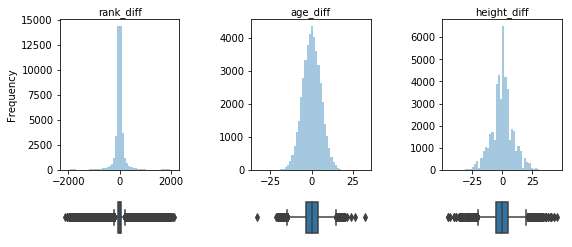

In [105]:
# Check distribution of normal features
check_distribution(total, ['rank_diff', 'age_diff', 'height_diff'])

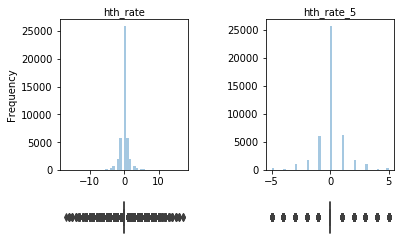

In [106]:
# Check distribution of hth features
check_distribution(total, ['hth_rate', 'hth_rate_5'])

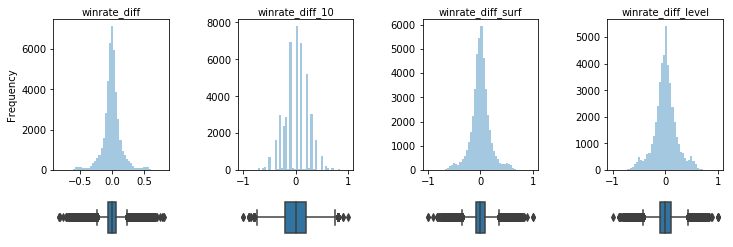

In [107]:
# Check distribution of winrate features
check_distribution(total, ['winrate_diff', 'winrate_diff_10', 'winrate_diff_surf', 'winrate_diff_level'])

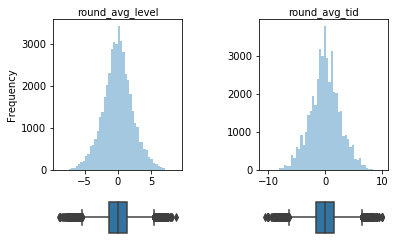

In [108]:
# Check distribution of round features
check_distribution(total, ['round_avg_level', 'round_avg_tid'])

### 3.4.2 Normalize Numerical Features
Normalize to ensure that each feature is treated equally when applying supervised learners.

In [109]:
# Show an example of records before scaling applied
total.head()

,tourney_id,tourney_year,match_num,surface,tourney_level,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
0,2008-891,2008,1,Hard,A,0.0,0.0,-121.0,-1.25,2.0,0.2540,0.3,0.2091,0.2705,4.566860,3.625000,1
2,2008-891,2008,3,Hard,A,0.0,0.0,-97.0,-2.94,5.0,-0.0367,0.2,-0.1629,0.0260,0.678992,4.500000,1
4,2008-891,2008,5,Hard,A,0.0,0.0,-108.0,8.73,2.0,0.1751,0.1,0.0727,0.4086,2.021670,4.250000,1
6,2008-891,2008,7,Hard,A,0.0,0.0,-32.0,0.64,-3.0,0.0014,0.2,0.0408,0.0089,0.932382,0.480769,1
8,2008-891,2008,9,Hard,A,0.0,0.0,-42.0,1.86,-7.0,-0.0161,0.0,-0.0541,0.0800,1.138889,1.138889,1


In [110]:
# Initialize a scaler
scaler = MinMaxScaler(feature_range=(0, 1))
numerical = ['hth_rate', 'hth_rate_5', 'rank_diff', 'age_diff', 'height_diff', 'winrate_diff', 'winrate_diff_10', 'winrate_diff_surf', 'winrate_diff_level', 'round_avg_level', 'round_avg_tid']

# Apply scalar to features
total_norm = pd.DataFrame(data = total)
total_norm[numerical] = scaler.fit_transform(total[numerical])

# Show an example of a record with scaling applied
display(total_norm.head(n = 5))

,tourney_id,tourney_year,match_num,surface,tourney_level,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
0,2008-891,2008,1,Hard,A,0.5,0.5,0.471654,0.488291,0.522222,0.664475,0.65,0.60455,0.63525,0.761026,0.689865,1
2,2008-891,2008,3,Hard,A,0.5,0.5,0.477299,0.462591,0.555556,0.485835,0.60,0.41855,0.51300,0.540120,0.732432,1
4,2008-891,2008,5,Hard,A,0.5,0.5,0.474712,0.640055,0.522222,0.615990,0.55,0.53635,0.70430,0.616410,0.720270,1
6,2008-891,2008,7,Hard,A,0.5,0.5,0.492590,0.517032,0.466667,0.509248,0.60,0.52040,0.50445,0.554517,0.536902,1
8,2008-891,2008,9,Hard,A,0.5,0.5,0.490238,0.535584,0.422222,0.498494,0.50,0.47295,0.54000,0.566251,0.568919,1


In [111]:
# Verify that all values are between 0 and 1
total_norm.describe()

,tourney_year,match_num,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
count,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000
mean,2012.789842,308.782458,0.500271,0.500803,0.500432,0.507386,0.500010,0.508095,0.500662,0.499832,0.499792,0.500501,0.512641,0.500011
std,3.099055,310.697241,0.046798,0.124853,0.085383,0.084323,0.098920,0.088687,0.117038,0.093821,0.106589,0.126825,0.127286,0.500006
min,2008.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,23.000000,0.500000,0.500000,0.487415,0.451034,0.444444,0.472009,0.400000,0.456100,0.446400,0.423542,0.434054,0.000000
50%,2013.000000,220.000000,0.500000,0.500000,0.500353,0.507299,0.500000,0.508204,0.500000,0.500000,0.500000,0.501540,0.513514,1.000000
75%,2015.000000,708.000000,0.500000,0.500000,0.513291,0.564173,0.555556,0.543969,0.600000,0.544100,0.553150,0.578122,0.589740,1.000000
max,2018.000000,946.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.4.3 Categorical Variables
Create dummy variables for categorical variables using one-hot encoding.

In [112]:
# Create dummy variables
total_final = pd.get_dummies(total_norm, columns=['surface', 'tourney_level'], dummy_na=False, prefix_sep='_')
total_final.head()

,tourney_id,tourney_year,match_num,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_G,tourney_level_M
0,2008-891,2008,1,0.5,0.5,0.471654,0.488291,0.522222,0.664475,0.65,0.60455,0.63525,0.761026,0.689865,1,0,0,0,1,1,0,0
2,2008-891,2008,3,0.5,0.5,0.477299,0.462591,0.555556,0.485835,0.60,0.41855,0.51300,0.540120,0.732432,1,0,0,0,1,1,0,0
4,2008-891,2008,5,0.5,0.5,0.474712,0.640055,0.522222,0.615990,0.55,0.53635,0.70430,0.616410,0.720270,1,0,0,0,1,1,0,0
6,2008-891,2008,7,0.5,0.5,0.492590,0.517032,0.466667,0.509248,0.60,0.52040,0.50445,0.554517,0.536902,1,0,0,0,1,1,0,0
8,2008-891,2008,9,0.5,0.5,0.490238,0.535584,0.422222,0.498494,0.50,0.47295,0.54000,0.566251,0.568919,1,0,0,0,1,1,0,0


## 3.5 Shuffle and Split Data
Separate target variable from features and make sure that the challenge data is not used as input for model training and testing.

### 3.5.1 Challenge Data
Save challenge data to be used for predictions later.

In [113]:
# Separate out 2018 data that will be used for challenge
challenge = total_final[total_final['tourney_year'] == 2018].copy()

# Filter to only include matches selected for challenge
challenge = pd.merge(challenge, tdc_2018_df, how='inner', on=['tourney_id', 'match_num'])

# Randomize order of data
challenge = challenge.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Split the data into features and target label
y_challenge = challenge['player_1_win']
X_challenge = challenge.drop(['player_1_win', 'tourney_id', 'match_num', 'tourney_year'], axis = 1)

# Check shape after split
print('Shape of X_challenge: {}'.format(X_challenge.shape))
print('Shape of y_challenge: {}'.format(y_challenge.shape))

# Verify that challenge data only contain 2018
challenge.groupby('tourney_year').size().to_frame()

Shape of X_challenge: (1758, 18)
Shape of y_challenge: (1758,)


,0
tourney_year,
2018,1758


In [114]:
# Verify that y classes are even for challenger set
print("Challenge set has an average of {} for y.".format(round(y_challenge.mean(), 4)))

Challenge set has an average of 0.4994 for y.


### 3.5.2 Train and Test Data
Take out challenge data so it's not included when training model.

In [115]:
# Exclude challenge data
train_test = total_final[total_final['tourney_year'] < 2018].copy()

# Randomize order of data
train_test = train_test.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Split the data into features and target label
y = train_test['player_1_win']
X = train_test.drop(['player_1_win', 'tourney_id', 'match_num', 'tourney_year'], axis = 1)

# Check shape after split
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

# Verify that data doesn't contain 2018 data
train_test.groupby('tourney_year').size().to_frame()

Shape of X: (40623, 18)
Shape of y: (40623,)


,0
tourney_year,
2008,4167
2009,4326
2010,4316
2011,4259
2012,4269
2013,4304
2014,4228
2015,4268
2016,3868


In [116]:
# Split the features and target data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 32498 samples.
Testing set has 8125 samples.


In [117]:
# Verify that y are evenly split between train and test sets
print("Training set has an average of {} for y.".format(round(y_train.mean(), 4)))
print("Testing set has an average of {} for y.".format(round(y_test.mean(), 4)))

Training set has an average of 0.4985 for y.
Testing set has an average of 0.5062 for y.


## 3.6 Evaluate Model Performance
Test how well different models can predict the outcome of the tennis matches. As the outcome of a tennis match is known and there are two players and only one winner, this is a binary classification problem where we can use supervised learning. I will evaluate the following classifiers:
- Logistic Regression
- Gaussian Naive Bayes
- Random Forest
- XGBoost

### 3.6.1 Metric Chosen
Earlier in the data preparation we made sure that 50% of the data had player 1 as winner and 50% had player 2 as winner. Since the classification distribution is balanced, we will use **accuracy** as the metric for evaluation model performance. Accuracy measures how often the classifier makes the correct prediction. It's calculated by taking:

- Number of correct predictions / Total number of predictions

In [118]:
# Verify that classes are balanced for test set
accuracy_check = accuracy_score(y_test, np.ones(len(y_test)))
print("Always 1 Predictor: [Accuracy score: {:.4f}]".format(accuracy_check))

Always 1 Predictor: [Accuracy score: 0.5062]


### 3.6.2 Training and Predicting Pipeline
Creating a pipeline that can be reused later.

In [119]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    Train and predict and return dictionary with results.
    
    INPUT:
    (clf) learner - the learning algorithm to be trained and predicted on
    (dataframe) X_train - features training set
    (dataframe) y_train - target training set
    (dataframe) X_test - features testing set
    (dataframe) y_test - target testing set
    
    OUTPUT:
    (dict) results - results from training and testing 
    '''
    
    # Dictionary for results
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = round(end - start, 4)
        
    # Get the predictions
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = round(end - start, 4)
            
    # Compute accuracy on the training samples
    results['acc_train'] = round(accuracy_score(y_train, predictions_train), 4)
        
    # Compute accuracy on test set 
    results['acc_test'] = round(accuracy_score(y_test, predictions_test), 4)
     
    # Return the results
    return results

### 3.6.3 Feature Selection
I want to check if all features are relevant so I prepare a subset of features to build and test model on as well. I apply a logistic regression model to each feature individually and see the accuracy. Based on the analysis below I see that all of the categorical features (tourney_level_ and surface_) have an accuracy less than 50% and therefore leave them out.

In [120]:
# Initialize the model
LR_model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)

# Get result for each column
results = {}
for column in X_train.columns:
    results[column] = train_predict(LR_model, X_train[column].values.reshape(-1, 1), y_train, X_test[column].values.reshape(-1, 1), y_test)

# Present result
results_df = pd.DataFrame(results)
results_df.T.sort_values('acc_test', ascending=[False])

,acc_test,acc_train,pred_time,train_time
rank_diff,0.6642,0.6723,0.0004,0.0458
round_avg_level,0.6431,0.6547,0.0004,0.0357
winrate_diff,0.6326,0.6403,0.0004,0.0357
round_avg_tid,0.6309,0.6409,0.0004,0.0353
winrate_diff_surf,0.6271,0.6320,0.0004,0.0368
winrate_diff_level,0.6144,0.6064,0.0004,0.0331
winrate_diff_10,0.5927,0.5927,0.0004,0.0324
hth_rate_5,0.5457,0.5454,0.0004,0.0280
hth_rate,0.5455,0.5454,0.0004,0.4481
height_diff,0.5154,0.5146,0.0004,0.0251


In [121]:
# Create list of best feature names
best_features = ['rank_diff', 'round_avg_level', 'round_avg_tid', 'winrate_diff', 'winrate_diff_surf', 'winrate_diff_level', 'winrate_diff_10', 'height_diff', 'hth_rate_5', 'hth_rate', 'age_diff']

### 3.6.4 Initial Model Evaluation
Here four different models are trained and tested. First they are tested on all the features available and then again tested on the subset of features found in the feature selection step above. I can see that:
- XGBClassifier performs much better than the other models
- When training on selected features there isn't much difference compared to when using all features.
- RandomForestClassifer have a much higher training accuracy than testing accuracy and seems to be overfitting.
- XGB and random forest are chosen to be tuned and evaluate further. In addition all features are decided to be used.

#### 3.6.4.1 All Features
Train and test on all features.

In [122]:
# Initialize four models
clf_LR = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
clf_GNB = GaussianNB()
clf_RF = RandomForestClassifier(n_estimators=10, random_state=42)
clf_XGB = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                            max_depth = 5, alpha = 10, n_estimators = 10, random_state=42)

# Collect results on the learners
results = {}
for clf in [clf_LR, clf_GNB, clf_RF, clf_XGB]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

# Present result
results_df = pd.DataFrame(results)
results_df

,LogisticRegression,GaussianNB,RandomForestClassifier,XGBClassifier
acc_test,0.6738,0.6618,0.6751,0.6937
acc_train,0.6862,0.6714,0.9858,0.7154
pred_time,0.0038,0.0095,0.1057,0.0333
train_time,0.6225,0.0097,0.6751,0.2333


#### 3.6.4.2 Selected Features
Train and test on selected features.

In [123]:
# Initialize four models
clf_LR_SF = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
clf_GNB_SF = GaussianNB()
clf_RF_SF = RandomForestClassifier(n_estimators=10, random_state=42)
clf_XGB_SF = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

# Collect results on the learners
results = {}
for clf in [clf_LR_SF, clf_GNB_SF, clf_RF_SF, clf_XGB_SF]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train[best_features], y_train, X_test[best_features], y_test)

# Present result
results_df = pd.DataFrame(results)
results_df

,LogisticRegression,GaussianNB,RandomForestClassifier,XGBClassifier
acc_test,0.6745,0.6613,0.6724,0.6964
acc_train,0.6862,0.6707,0.9854,0.7175
pred_time,0.0023,0.0062,0.1042,0.0287
train_time,0.1251,0.0077,0.7456,0.2102


### 3.6.5 Model Tuning
XGBoost was the best based on the tuning:
- Random Forest got 69.11% accuracy on test data
- XGBoost got 71.88% accuracy on test data

#### 3.6.5.1 Random Forest
Train and test a Random Forest classifier.

In [124]:
# Get start time
start = time() 

# Initialize the classifier
RF_clf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

# Create the parameters list to tune on
parameters = {'n_estimators': [16, 18, 20], 
              'max_depth': [10, 12, 14], 
              'min_samples_leaf': [2, 4, 6], 
              'min_samples_split': [14, 16, 18]}

# TODO: Make an accuracy_score scoring object using make_scorer()
scorer = make_scorer(accuracy_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(RF_clf, parameters, cv=5, scoring=scorer, verbose=4, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_RF_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (RF_clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_RF_clf.predict(X_test)

# Convert to minutes
time_minutes = round((time()-start)/60, 1)

# Report the before-and-afterscores
print("Unoptimized model: Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Optimized Model: Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print('Tuning took: {} minutes'.format(time_minutes))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.4min finished


Unoptimized model: Accuracy score on testing data: 0.6751
Optimized Model: Final accuracy score on the testing data: 0.6911
Tuning took: 1.4 minutes


In [125]:
# Check parameters for best model
best_RF_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### 3.6.5.2 XGBoost
Train and test XGBoost classifier.

In [126]:
# Get start time
start = time() 

# Initialize the classifier
XGB_clf = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10, n_jobs=-1, random_state=42)

# Create the parameters list to tune on
parameters = {'learning_rate': [0.7, 0.75, 0.8],
              'max_depth': [5, 6, 7],
              'n_estimators': [11, 12, 13],
              'subsample': [0.9, 0.95, 1],
              'colsample_bytree': [0.70, 0.75, 0.80],
              'alpha': [1, 2, 3]
             }

# Make an accuracy_score scoring object using make_scorer()
scorer = make_scorer(accuracy_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(XGB_clf, parameters, cv=5, scoring=scorer, verbose=4, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_XGB_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (XGB_clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_XGB_clf.predict(X_test)

# Convert to minutes
time_minutes = round((time()-start)/60, 1)

# Report the before-and-afterscores
print("Unoptimized model: Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Optimized Model: Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print('Tuning took: {} minutes'.format(time_minutes))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2957 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 3645 out of 3645 | elapsed:  7.3min finished


Unoptimized model: Accuracy score on testing data: 0.6937
Optimized Model: Final accuracy score on the testing data: 0.7188
Tuning took: 7.3 minutes


In [127]:
# Check parameters for best model
best_XGB_clf

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.75,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=13, n_jobs=-1, nthread=None, objective='reg:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.95)

### 3.6.6 Feature Importance
Count the number of times each feature is split on across all boosting rounds (trees) in the model.

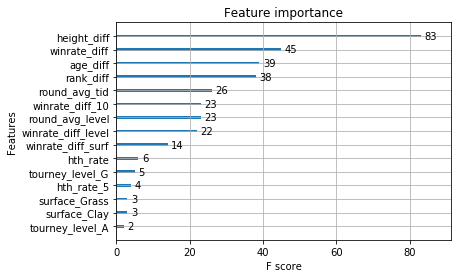

In [128]:
# Check which features were most important
ax = xgb.plot_importance(best_XGB_clf)

## 3.7 Predict on Challenge
Use all trained model and see how they perform for the challenge data. The XGBoost model is in a league of its own and get a much better prediction result than the other models.

In [129]:
def predict_challenge(learner, X_challenge, y_challenge): 
    '''
    Predict on challenge data and return dictionary with results.
    
    INPUT:
    (clf) learner - the learning algorithm to use for prediction
    (dataframe) X_challenge - features challenge set
    (dataframe) y_challenge - target challenge set
    
    OUTPUT:
    (dict) results - results from training and testing
    '''
    
    # Dictionary for results
    results = {}
        
    # Get the predictions
    pred_challenge = learner.predict(X_challenge)
    results['predictions'] = pred_challenge

    # Compute accuracy on test set 
    results['acc_challenge'] = round(accuracy_score(y_challenge, pred_challenge), 4)
        
    # Return the results
    return results

In [130]:
# Collect results on the learners
results = {}
for clf in [clf_LR, clf_GNB, best_RF_clf, best_XGB_clf]:
    clf_name = clf.__class__.__name__
    results[clf_name] = predict_challenge(clf, X_challenge, y_challenge)

# Present result
results_df = pd.DataFrame(results).T
results_df['acc_challenge'].to_frame().sort_values(['acc_challenge'], ascending=[False])

,acc_challenge
XGBClassifier,0.7582
RandomForestClassifier,0.6854
LogisticRegression,0.6388
GaussianNB,0.6149


In [131]:
# Get best prediction data
challenge_pred_df = pd.DataFrame()
challenge_pred_df['Actual'] = y_challenge
challenge_pred_df['Predicted'] = results_df['predictions']['XGBClassifier']
challenge_pred_df['Correct'] = np.where(challenge_pred_df['Actual'] == challenge_pred_df['Predicted'], 1, 0)

# Calculate best prediction
all_model = len(challenge_pred_df)
correct_model = challenge_pred_df['Correct'].sum()
model_accuracy = round(100 * correct_model / all_model, 1)

# Display result
print('Model prediction: {} of {} correct - {}%'.format(correct_model, all_model, model_accuracy))

Model prediction: 1333 of 1758 correct - 75.8%


----
# 4. Evaluate Challenge Predictions
When we compare the predictions we can see that the fantasy tennis player performed much better than the benchmark prediction. However, the machine learning prediction was the clear winner, predicting far more matches correct than the other two:

- **Benchmark prediction**: 1101 of 1758 correct - 62.6%
- **FTP prediction**: 1168 of 1758 correct - 66.4%
- **Machine Learning prediction**: 1333 of 1758 correct - 75.8%

In [132]:
# Prepare data for plot
data = {'classifier': ['Machine Learning Model', 'Best Fantasy Tennis Player', 'Benchmark'], 
        'accuracy': [model_accuracy, ftp_accuracy, benchmark_accuracy]}
pred_df = pd.DataFrame(data)
pred_df

,classifier,accuracy
0,Machine Learning Model,75.8
1,Best Fantasy Tennis Player,66.4
2,Benchmark,62.6


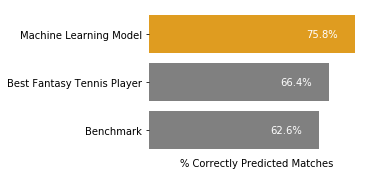

In [133]:
# Create plot
colors = ['grey' if (x < max(pred_df['accuracy'])) else 'orange' for x in pred_df['accuracy']]
plt.figure(figsize = (3,2))
ax = plt.axes([0,0,1,1], frameon=False)
ax = sns.barplot(pred_df.accuracy, pred_df.classifier, palette = colors)
ax.set(xlabel='% Correctly Predicted Matches', ylabel='')
ax.get_xaxis().set_ticks([])

# add annotations
locs, labels = plt.yticks() # get the current tick locations and label

# loop through each pair of locations and labels
for y_loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    pct = pred_df.loc[y_loc, 'accuracy']
    pct_string = '{}%'.format(pct)

    # print the annotation just below the top of the bar
    ax.text(pct-18, y_loc, pct_string, va= 'center', color = 'white', weight='normal')